In [1]:
"""──────────────────────────────────────────────────────────────────────────┐
│ Loading necessary libraries to build and train model                       │
└──────────────────────────────────────────────────────────────────────────"""
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import os,sys,gc
import numpy as np
import pickle
import torch
import proplot as plot
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import pandas as pd
import glob
import properscoring as ps
from copy import deepcopy
plot.rc.update({'figure.facecolor':'w','axes.labelweight':'ultralight',
                'tick.labelweight':'ultralight','gridminor.linestyle':'--','title.weight':'normal','linewidth':0.5})
import random
import sys
sys.path.insert(1, '/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/2024_TCG_VED_WRFsen/')
from util.ml import (preproc,vae,benchmark)
from util.wrf_process import (read_and_write)
import read_config

In [2]:
suffix='/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/2024_TCG_VED_WRFsen/'
config_set = read_config.read_config('../../config.ini')
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [3]:
def flatten(xss):
    return [x for xs in xss for x in xs]

# Experiment Type

In [4]:
exp = int(3100)

# Process

In [5]:
alldicts_seeds = {}
for i in tqdm(range(19)):
    alldicts = {}
    for j in ([0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95]):
        alldicts[j] = benchmark.ved_analysis(i,j,10,2,f'storage/proc/PCA/{exp}/PCAsmooth{exp}*',
                                   f'storage/proc/Xsmooth/{exp}/Xtimeseries*',f'storage/proc/VEDsmooth_{exp}/',12).inner_loop_scores(suffix,config_set,30)
    alldicts_seeds[i] = alldicts

  0%|          | 0/19 [00:00<?, ?it/s]

In [6]:
coeffs = [0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95]
bestsplit_loc,bestcoeff_loc,bestmodel_loc,bestscore = benchmark.find_best_model_loc(alldicts_seeds,'valid','r2')
allscoress = benchmark.output_1score(alldicts_seeds,'valid','r2')
_,_,_,numcomps,NT_data,validindices = benchmark.ved_analysis(bestsplit_loc,coeffs[bestcoeff_loc],10,2,f'storage/proc/PCA/{exp}/PCAsmooth{exp}*',
                                   f'storage/proc/Xsmooth/{exp}/Xtimeseries*',f'storage/proc/VEDsmooth_{exp}/',12).get_data(suffix,config_set)
PCA = read_and_write.depickle(sorted(glob.glob(suffix+f'storage/proc/PCA/{exp}/PCAsmooth{exp}*'))[bestsplit_loc])

In [7]:
bestsplit_loc

18

## Sensitivity test: Performance

In [7]:
#3050
import gc
print(np.mean(flatten([(obj[bestcoeff_loc]) for obj in (allscoress)])),np.max((flatten([(obj[bestcoeff_loc]) for obj in (allscoress)]))))

-0.06375428250173114 0.15991192370178353


In [7]:
#3100
import gc
print(np.mean(flatten([(obj[bestcoeff_loc]) for obj in (allscoress)])),np.max((flatten([(obj[bestcoeff_loc]) for obj in (allscoress)]))))

-0.010174922098142984 0.22850802004677417


In [7]:
#6020
import gc
print(np.mean(flatten([(obj[bestcoeff_loc]) for obj in (allscoress)])),np.max((flatten([(obj[bestcoeff_loc]) for obj in (allscoress)]))))

-0.015976325445868942 0.19808652818008055


In [7]:
#6050
import gc
print(np.mean(flatten([(obj[bestcoeff_loc]) for obj in (allscoress)])),np.max((flatten([(obj[bestcoeff_loc]) for obj in (allscoress)]))))

-0.0031500214136129224 0.18276615102922888


In [11]:
#6100
import gc
print(np.mean(flatten([(obj[bestcoeff_loc]) for obj in (allscoress)])),np.max((flatten([(obj[bestcoeff_loc]) for obj in (allscoress)]))))

-0.03704964873410781 0.09391349701326401


In [73]:
#9020
np.mean(flatten([(obj[bestcoeff_loc]) for obj in (allscoress)])),np.max((flatten([(obj[bestcoeff_loc]) for obj in (allscoress)])))

(0.0027769996334217092, 0.1875888964374267)

In [69]:
#9050
import gc
np.mean(flatten([(obj[bestcoeff_loc]) for obj in (allscoress)])),np.max((flatten([(obj[bestcoeff_loc]) for obj in (allscoress)])))
del alldicts_seeds,PCA
gc.collect()

(-0.037142778401214584, 0.051340610744488036)

In [8]:
#9100
np.mean(flatten([(obj[bestcoeff_loc]) for obj in (allscoress)])),np.max((flatten([(obj[bestcoeff_loc]) for obj in (allscoress)])))

(-0.024746200474774247, 0.056354779174928704)

In [ ]:
del alldicts_seeds,PCA
gc.collect()

## Look at the structure

In [10]:
def model_outweights_all(model=None):
    params,names = [],[]
    for name, param in model.named_parameters():
        params.append(param)
        names.append(name)
    return params, names

def model_outweights(model=None):
    params,names = [],[]
    for name, param in model.named_parameters():
        if ".weight" not in name:
            continue            
        else:
            params.append(param)
            names.append(name)
    return params, names

In [11]:
bestmodel = alldicts_seeds[bestsplit_loc][coeffs[bestcoeff_loc]][bestmodel_loc]['model']
flLW = benchmark.analysis_patterns(None,None).new_structure_vae(X_totrain=NT_data['train'][0],
                                                      bestmodel=bestmodel,
                                                      TYPE='LW',
                                                      varINDX=np.asarray(numcomps).cumsum()
                                                     )
flSW = benchmark.analysis_patterns(None,None).new_structure_vae(X_totrain=NT_data['train'][0],
                                                      bestmodel=bestmodel,
                                                      TYPE='SW',
                                                      varINDX=np.asarray(numcomps).cumsum()
                                                     )

In [12]:
LWstructure = np.squeeze(np.dot(flLW,PCA['PCA']['LW'].components_[:numcomps[1],:])).reshape(54,350,350)
SWstructure = np.squeeze(np.dot(flSW,PCA['PCA']['SW'].components_[:numcomps[2],:])).reshape(54,350,350)

In [37]:
read_and_write.save_to_pickle(LWstructure,'../../storage/output/LWstructure.pkl')
read_and_write.save_to_pickle(SWstructure,'../../storage/output/SWstructure.pkl')

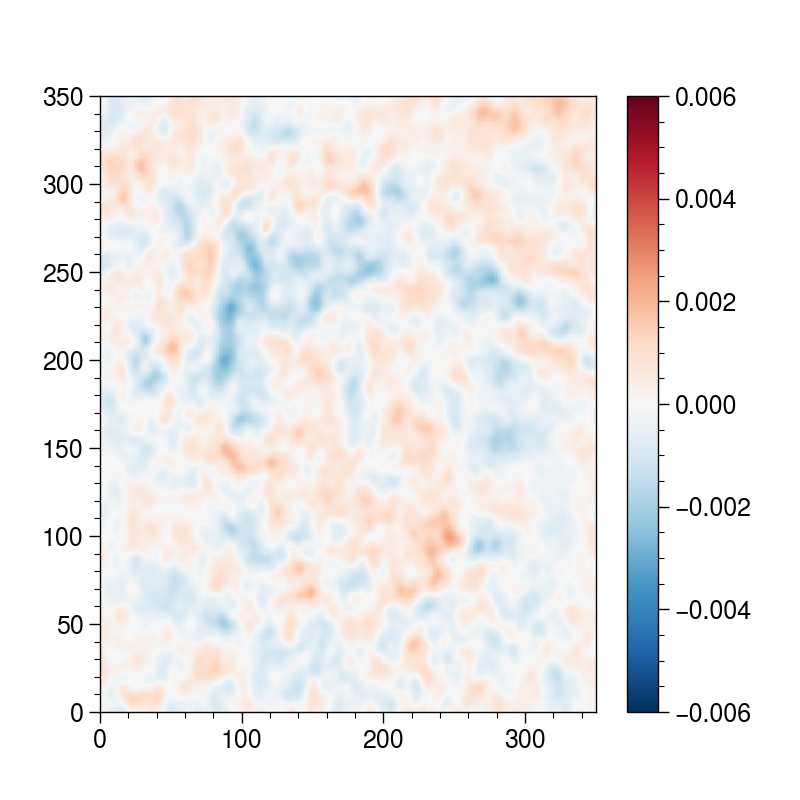

In [10]:
plt.pcolormesh(LWstructure[37,:],vmin=-0.006,vmax=0.006,cmap='RdBu_r')
plt.colorbar()
plt.show()

In [38]:
from netCDF4 import Dataset
from wrf import (to_np, getvar, smooth2d, get_cartopy, cartopy_xlim,
                 cartopy_ylim, latlon_coords, interplevel)
ncfile = Dataset(sorted(glob.glob(f'../../storage/memb0{1}/wrfout_d02_2013-11-0*'))[0])
lons,lats,pres = read_and_write.get_basic_domain(ncfile)

In [39]:
test = getvar(ncfile, "REFL_10CM")

In [40]:
LWstructure_xr = test[:,:350,:350].copy(deep=True,data=LWstructure)
LWstructure_xr_1000 = interplevel(LWstructure_xr, pres[:,:350,:350], 1000*100)
LWstructure_xr_100 = interplevel(LWstructure_xr, pres[:,:350,:350], 100*100)

SWstructure_xr = test[:,:350,:350].copy(deep=True,data=SWstructure)
SWstructure_xr_1000 = interplevel(SWstructure_xr, pres[:,:350,:350], 1000*100)
SWstructure_xr_100 = interplevel(SWstructure_xr, pres[:,:350,:350], 100*100)

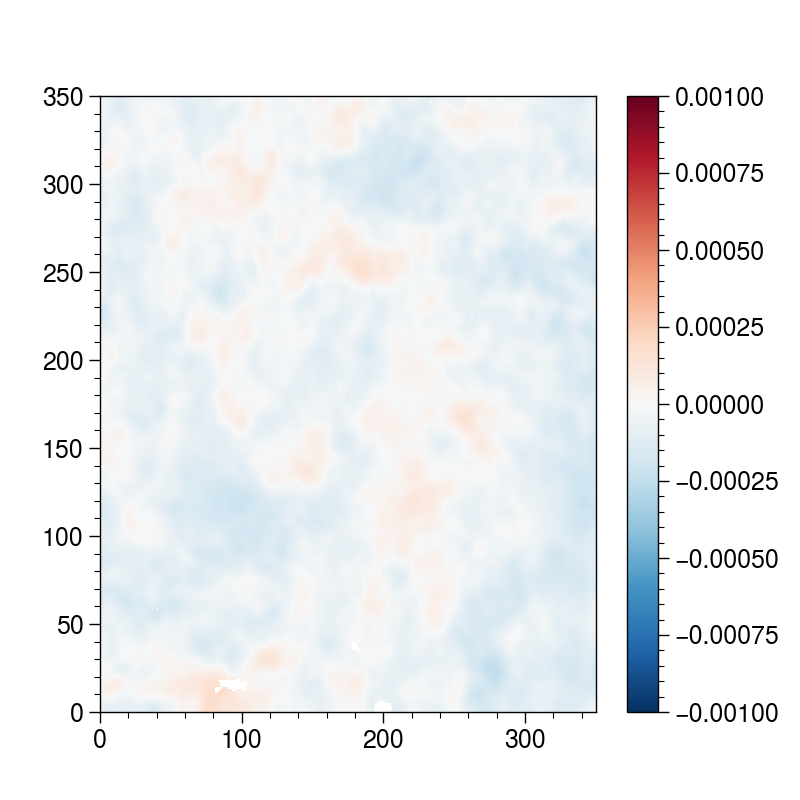

In [41]:
plt.pcolormesh(SWstructure_xr_1000,vmin=-0.001,vmax=0.001,cmap='RdBu_r')
plt.colorbar()
plt.show()

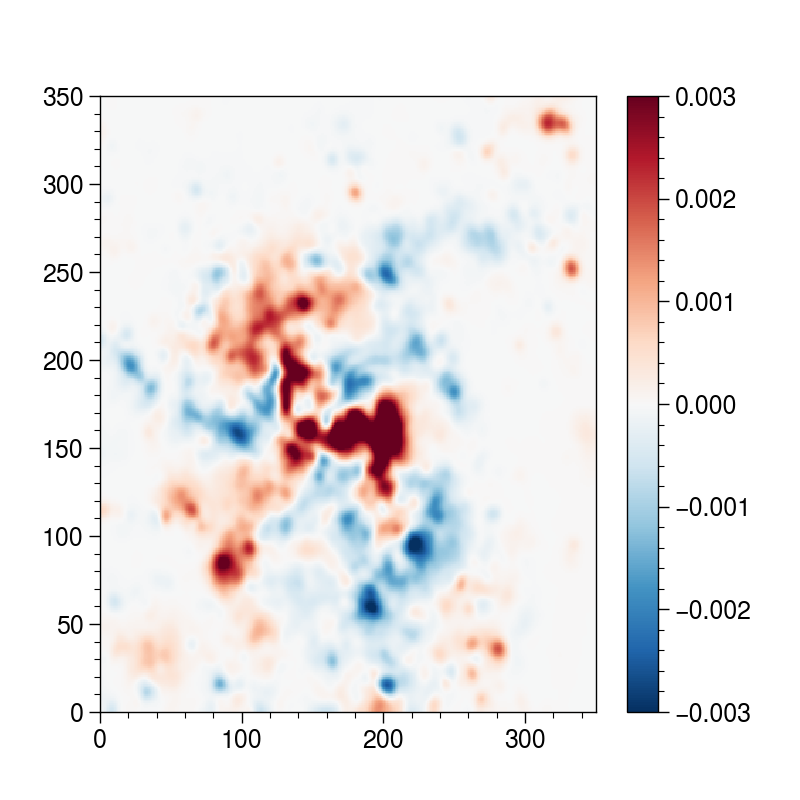

In [42]:
plt.pcolormesh(SWstructure_xr_100,vmin=-0.003,vmax=0.003,cmap='RdBu_r')
plt.colorbar()
plt.show()

In [19]:
from skimage.transform import resize
LWstructure_reshaped = []
for i in range(54):
    LWstructure_reshaped.append(resize(LWstructure[i,...],(350/5,350/5)))
#bottle_resized = resize(bottle, (140, 54))
read_and_write.save_to_pickle(np.asarray(LWstructure_reshaped),'../../storage/output/LWstructure_d01.pkl')

In [20]:
350/5

70.0

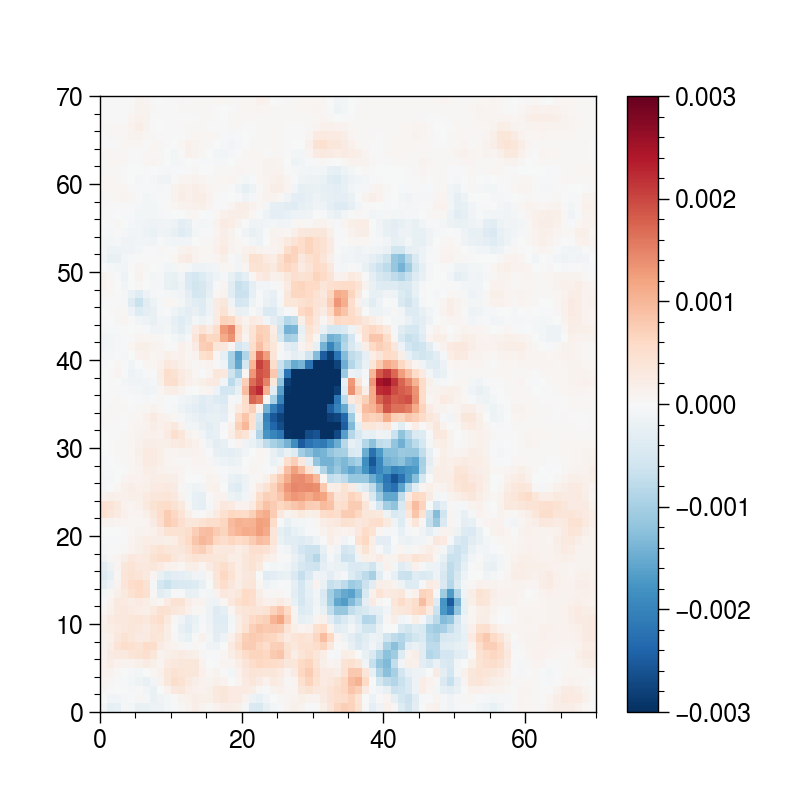

In [21]:
plt.pcolormesh(resize(LWstructure_xr_100,(350/5,350/5)),vmin=-0.003,vmax=0.003,cmap='RdBu_r')
plt.colorbar()
plt.show()

## Prediction

In [9]:
bestmodel = alldicts_seeds[bestsplit_loc][coeffs[bestcoeff_loc]][bestmodel_loc]['model']

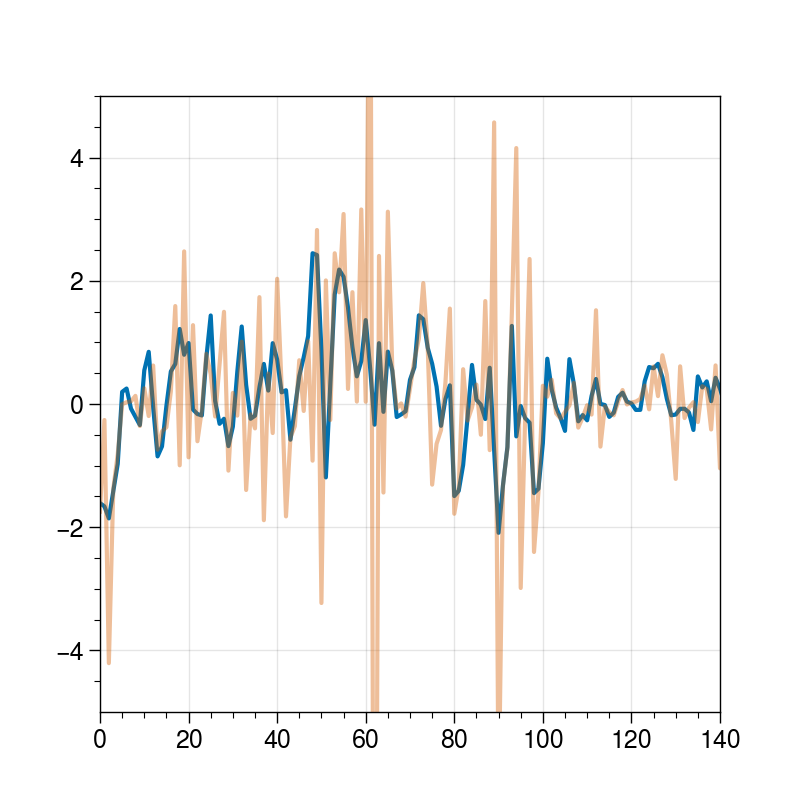

In [10]:
plt.plot(bestmodel(torch.Tensor((NT_data['train'])[0]))[0].detach().numpy())
plt.plot((NT_data['train'])[1],alpha=0.4)
plt.ylim(-5,5)
plt.xlim(0,140)
plt.show()

In [59]:
validindices

'9_5'

In [78]:
np.asarray(read_and_write.depickle(sorted(glob.glob(f'../../storage/memb10/proc/cutcart_rthratlw.pkl'))[0])['pol']).shape

(35, 54, 350, 350)

In [79]:
[(67,), (70,), (68,), (59,), (67,), (67,), (70,), (60,), (70,), (34,)]

[(67,), (70,), (68,), (59,), (67,), (67,), (70,), (60,), (70,), (34,)]

In [ ]:
sorted(glob.glob(f'../../storage/proc/PCA/{exptype}/PCAsmooth{exptype}*'))